In [1]:
### Load libraries
import pandas as pd
from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence
import numpy as np
from sklearn.model_selection import train_test_split

import sys, os
sys.path.append('Neural_Network_DNA_Demo/')
from helper import IOHelper, SequenceHelper # from https://github.com/bernardo-de-almeida/Neural_Network_DNA_Demo.git

### global variables
dinuc_shuffle_n=100

## Load Sequence

In [2]:
fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"

fname = "whole_genome_X.npy"
fpath = os.path.join(fdiry, fname)
with open(fpath, 'rb') as file:
    X = np.load(file)

fname = "whole_genome_Y.npy"
fpath = os.path.join(fdiry, fname)
with open(fpath, 'rb') as file:
    Y = np.load(file)

In [3]:
print(X.shape)
print(Y.shape)

(87909, 1000, 4)
(87909, 2)


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    Y, 
    test_size=0.2, 
    random_state=123)

## Load model

In [5]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
model_name = "Model_DeepSTARR"
model_ID = os.path.join(fdiry, "cradle_deepstarr_results", model_name)
model_ID

'/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results/Model_DeepSTARR'

In [6]:
### load model functions
def load_model(model):
    import deeplift
    from tensorflow.keras.models import model_from_json
    keras_model_weights = model + '.h5'
    keras_model_json = model + '.json'
    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    return keras_model, keras_model_weights, keras_model_json

In [7]:
keras_model, keras_model_weights, keras_model_json = load_model(model_ID)

W0123 22:17:58.103071 140139817756480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0123 22:17:58.105112 140139817756480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0123 22:17:58.106327 140139817756480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

## Get contri scores

In [8]:
keras_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
Conv1D_1st (Conv1D)             (None, 1000, 256)    7424        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 1000, 256)    1024        Conv1D_1st[0][0]                 
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 1000, 256)    0           batch_normalization_21[0][0]     
____________________________________________________________________________________________

In [9]:
keras_model.layers

In [10]:
keras_model.layers[-2]

In [11]:
keras_model.layers[-1]

In [12]:
keras_model.layers[-2].output

<tf.Tensor 'Dense_DMSO/BiasAdd:0' shape=(?, 1) dtype=float32>

In [13]:
### deepExplainer functions
def dinuc_shuffle_several_times(list_containing_input_modes_for_an_example,
                                seed=1234):
    assert len(list_containing_input_modes_for_an_example)==1
    onehot_seq = list_containing_input_modes_for_an_example[0]
    rng = np.random.RandomState(seed)
    to_return = np.array([dinuc_shuffle(onehot_seq, rng=rng) for i in range(dinuc_shuffle_n)])
    return [to_return] #wrap in list for compatibility with multiple modes

# get hypothetical scores also
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    assert len(orig_inp)==1
    projected_hypothetical_contribs = np.zeros_like(bg_data[0]).astype("float")
    assert len(orig_inp[0].shape)==2
    #At each position in the input sequence, we iterate over the one-hot encoding
    # possibilities (eg: for genomic sequence, this is ACGT i.e.
    # 1000, 0100, 0010 and 0001) and compute the hypothetical
    # difference-from-reference in each case. We then multiply the hypothetical
    # differences-from-reference with the multipliers to get the hypothetical contributions.
    #For each of the one-hot encoding possibilities,
    # the hypothetical contributions are then summed across the ACGT axis to estimate
    # the total hypothetical contribution of each position. This per-position hypothetical
    # contribution is then assigned ("projected") onto whichever base was present in the
    # hypothetical sequence.
    #The reason this is a fast estimate of what the importance scores *would* look
    # like if different bases were present in the underlying sequence is that
    # the multipliers are computed once using the original sequence, and are not
    # computed again for each hypothetical sequence.
    for i in range(orig_inp[0].shape[-1]):
        hypothetical_input = np.zeros_like(orig_inp[0]).astype("float")
        hypothetical_input[:,i] = 1.0
        hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[0])
        hypothetical_contribs = hypothetical_difference_from_reference*mult[0]
        projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1)
    return [np.mean(projected_hypothetical_contribs,axis=0)]

In [14]:
import shap # forked from https://github.com/AvantiShri/shap/blob/master/shap/explainers/deep/deep_tf.py
import numpy as np

In [15]:
X_valid.shape

(17582, 1000, 4)

In [16]:

# output layer
#if class_output=="dev":
#    out_layer=-2
#if class_output=="hk":
#    out_layer=-1
model   = keras_model
one_hot = X_valid[:5]
out_layer = -1

explainer = shap.DeepExplainer(
    (model.layers[0].input, model.layers[out_layer].output),
    data=dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

# running on all sequences
shap_values_hypothetical = explainer.shap_values(one_hot)

Using TensorFlow backend.
W0123 22:19:08.952094 140139817756480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/shap/explainers/deep/deep_tf.py:137: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0123 22:19:09.154731 140139817756480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/shap/explainers/deep/deep_tf.py:496: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
len(shap_values_hypothetical)

1

In [18]:
shap_values_hypothetical[0].shape

(5, 1000, 4)

In [19]:
shap_values_contribution=shap_values_hypothetical[0]*one_hot
shap_values_contribution.shape

(5, 1000, 4)

In [24]:
TASK1="DMSO"
TASK2="Dex"
def my_deepExplainer(model, one_hot, class_output):
    import shap # forked from https://github.com/AvantiShri/shap/blob/master/shap/explainers/deep/deep_tf.py
    import numpy as np

    # output layer
    #if class_output=="dev":
    if class_output==TASK1:
        out_layer=-2
    #if class_output=="hk":
    if class_output==TASK2:
        out_layer=-1

    
    explainer = shap.DeepExplainer(
        (model.layers[0].input, model.layers[out_layer].output),
         data=dinuc_shuffle_several_times,
         combine_mult_and_diffref=combine_mult_and_diffref)

    # running on all sequences
    shap_values_hypothetical = explainer.shap_values(one_hot)

    # normalising contribution scores
    # sum the deeplift importance scores across the ACGT axis (different nucleotides at the same position)
    # and “project” that summed importance onto whichever base is actually present at that position
    shap_values_contribution=shap_values_hypothetical[0]*one_hot
    # my note: 
    #     shap_values_hypothetical is a list
    #     shap_values_hypothetical.shape => (#sequence, length, 4)

    return shap_values_hypothetical[0], shap_values_contribution
    #return shap_values_hypothetical, shap_values_contribution
    

In [25]:
print("\nRunning DeepExplain ...\n")

X_sub = X_valid[:5]
class_output = TASK1
scores_task1=my_deepExplainer(keras_model, X_sub, class_output=class_output)

class_output = TASK2
scores_task2=my_deepExplainer(keras_model, X_sub, class_output=class_output)


Running DeepExplain ...



In [26]:
len(scores_task1)

2

In [29]:
print(len(scores_task1))
print(scores_task1[0].shape)
print(scores_task1[1].shape)
print(len(scores_task2))
print(scores_task2[0].shape)
print(scores_task2[1].shape)

2
(5, 1000, 4)
(5, 1000, 4)
2
(5, 1000, 4)
(5, 1000, 4)


In [13]:
print("\nRunning DeepExplain ...\n")

class_output = TASK1
scores_task1=my_deepExplainer(keras_model, X, class_output=class_output)

class_output = TASK2
scores_task2=my_deepExplainer(keras_model, X, class_output=class_output)


Running DeepExplain ...



Using TensorFlow backend.
W0114 13:05:41.519101 140467713832768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/shap/explainers/deep/deep_tf.py:137: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0114 13:05:41.645146 140467713832768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/shap/explainers/deep/deep_tf.py:496: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Save the scores

In [14]:
print("\nSaving ...\n")

import h5py
import os
model_ID_out=os.path.basename(model_ID)
model_ID_out


Saving ...



'Model_DeepSTARR'

In [15]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
fpath = os.path.join(
    fdiry, 
    "cradle_deepstarr_results", 
    "WG_" + model_ID_out + "_" + class_output + "_contribution_scores.h5")
fpath

'/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results/WG_Model_DeepSTARR_Dex_contribution_scores.h5'

In [30]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
fpath = os.path.join(
    fdiry, 
    "cradle_deepstarr_results", 
    "WG_" + model_ID_out + "_contribution_scores.h5")
fpath

NameError: name 'model_ID_out' is not defined

In [18]:
print("\nSaving ...\n")

import h5py
import os
model_ID_out=os.path.basename(model_ID)

#if (os.path.isfile(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")):
#    os.remove(str(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5"))
#f = h5py.File(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")

if (os.path.isfile(fpath)):
    os.remove(str(fpath))
f = h5py.File(fpath)


g = f.create_group("contrib_scores")
# save the actual contribution scores
#g.create_dataset(class_output, data=scores[1])
g.create_dataset(TASK1, data=scores_task1[1])
g.create_dataset(TASK2, data=scores_task2[1])
print("Done contr scores for " + class_output)

g = f.create_group("hyp_contrib_scores")
# save the hypothetical contribution scores
#g.create_dataset(class_output, data=scores[0])
g.create_dataset(TASK1, data=scores_task1[0])
g.create_dataset(TASK2, data=scores_task2[0])
print("Done hyp scores for " + class_output)

f.close()


Saving ...

Done contr scores for Dex
Done hyp scores for Dex


## Visualization

In [35]:
print(type(scores))
print(len(scores))
print(type(scores[0]), type(scores[1]))
print("Scores[0]")
print(scores[0].shape)
print("Scores[1]")
print(scores[1].shape)

<class 'tuple'>
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Scores[0]
(1000, 1000, 4)
Scores[1]
(1000, 1000, 4)


In [36]:
from deeplift.visualization import viz_sequence

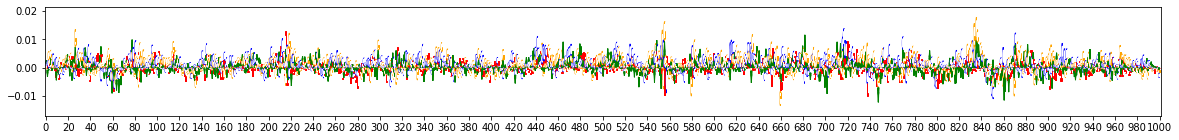

In [37]:
viz_sequence.plot_weights(scores[0][0], subticks_frequency=20)

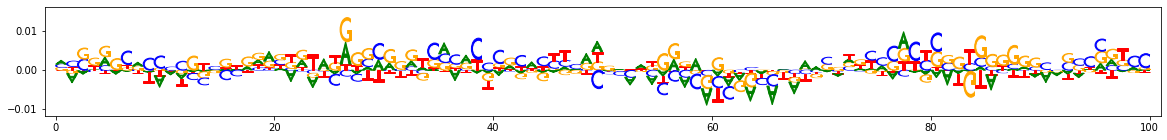

In [40]:
viz_sequence.plot_weights(scores[0][0][:100], subticks_frequency=20)

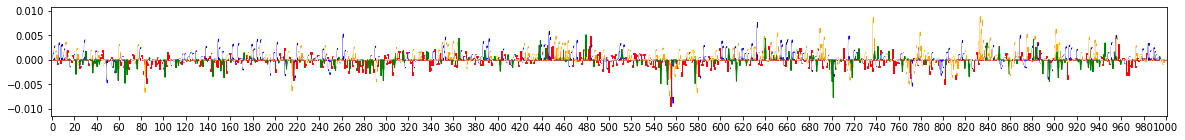

In [39]:
viz_sequence.plot_weights(scores[1][0], subticks_frequency=20)

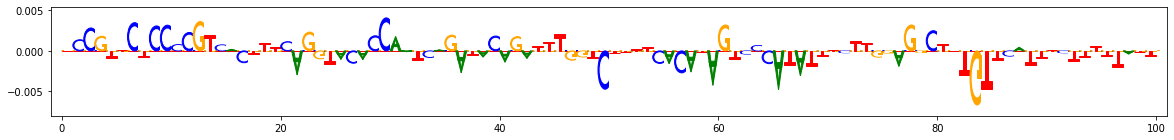

In [41]:
viz_sequence.plot_weights(scores[1][0][:100], subticks_frequency=20)


Saving ...



'Model_DeepSTARR'

In [44]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
fpath = os.path.join(
    fdiry, 
    "cradle_deepstarr_results", 
    "WG_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")
fpath

'/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results/WG_Model_DeepSTARR_Dex_contribution_scores.h5'

In [45]:
print("\nSaving ...\n")

import h5py
import os
model_ID_out=os.path.basename(model_ID)

#if (os.path.isfile(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")):
#    os.remove(str(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5"))
#f = h5py.File(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")

if (os.path.isfile(fpath)):
    os.remove(str(fpath))
f = h5py.File(fpath)


g = f.create_group("contrib_scores")
# save the actual contribution scores
g.create_dataset(class_output, data=scores[1])
print("Done contr scores for " + class_output)

g = f.create_group("hyp_contrib_scores")
# save the hypothetical contribution scores
g.create_dataset(class_output, data=scores[0])
print("Done hyp scores for " + class_output)

f.close()


Saving ...

Done contr scores for Dex
Done hyp scores for Dex


-----

In [1]:
### Load libraries
import pandas as pd
from deeplift.dinuc_shuffle import dinuc_shuffle
import numpy as np

import sys, os
sys.path.append('Neural_Network_DNA_Demo/')
from helper import IOHelper, SequenceHelper # from https://github.com/bernardo-de-almeida/Neural_Network_DNA_Demo.git

### global variables
dinuc_shuffle_n=100

### Load Arguments
#fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data"
#fdiry = "/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results"
fdiry = "/home/mount/work/out/proj_combeffect/peak"
model_name = "Model_DeepSTARR"
seq_name   = "chr17.fa"

TASK1="DMSO"
TASK2="Dex"

args = {
    #"m": "DeepSTARR.model", 
    #"m": "Model_DeepSTARR_tf114", 
    #"s": "Sequences_example.fa",
    #"c": "dev"
    "m": os.path.join(fdiry, "cradle_deepstarr_results", model_name), 
    "s": os.path.join(fdiry, "cradle_deepstarr_data",    seq_name),
    "c": "Dex"
}
model_ID = args["m"] 
sequence_set = args["s"]
class_output = args["c"]

In [2]:
os.listdir(fdiry)

['.ipynb_checkpoints',
 'cradle_deepstarr_results',
 'cradle_peak_count',
 'cradle',
 'cradle_deepstarr_data']

In [3]:
### load fasta sequences functions
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1):
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def prepare_input(file_seq):
    # Convert sequences to one-hot encoding matrix
    input_fasta_data_A = IOHelper.get_fastas_from_file(file_seq, uppercase=True)

    # get length of first sequence
    sequence_length = len(input_fasta_data_A.sequence.iloc[0])

    # Convert sequence to one hot encoding matrix
    seq_matrix_A = SequenceHelper.do_one_hot_encoding(input_fasta_data_A.sequence, sequence_length,
      SequenceHelper.parse_alpha_to_seq)
    print(seq_matrix_A.shape)

    X = np.nan_to_num(seq_matrix_A) # Replace NaN with zero and infinity with large finite numbers
    X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

    print(file_seq)

    return X_reshaped

In [1]:
### load model functions
def load_model(model):
    import deeplift
    from tensorflow.keras.models import model_from_json
    keras_model_weights = model + '.h5'
    keras_model_json = model + '.json'
    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    return keras_model, keras_model_weights, keras_model_json

In [5]:
### deepExplainer functions
def dinuc_shuffle_several_times(list_containing_input_modes_for_an_example,
                                seed=1234):
    assert len(list_containing_input_modes_for_an_example)==1
    onehot_seq = list_containing_input_modes_for_an_example[0]
    rng = np.random.RandomState(seed)
    to_return = np.array([dinuc_shuffle(onehot_seq, rng=rng) for i in range(dinuc_shuffle_n)])
    return [to_return] #wrap in list for compatibility with multiple modes

# get hypothetical scores also
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    assert len(orig_inp)==1
    projected_hypothetical_contribs = np.zeros_like(bg_data[0]).astype("float")
    assert len(orig_inp[0].shape)==2
    #At each position in the input sequence, we iterate over the one-hot encoding
    # possibilities (eg: for genomic sequence, this is ACGT i.e.
    # 1000, 0100, 0010 and 0001) and compute the hypothetical
    # difference-from-reference in each case. We then multiply the hypothetical
    # differences-from-reference with the multipliers to get the hypothetical contributions.
    #For each of the one-hot encoding possibilities,
    # the hypothetical contributions are then summed across the ACGT axis to estimate
    # the total hypothetical contribution of each position. This per-position hypothetical
    # contribution is then assigned ("projected") onto whichever base was present in the
    # hypothetical sequence.
    #The reason this is a fast estimate of what the importance scores *would* look
    # like if different bases were present in the underlying sequence is that
    # the multipliers are computed once using the original sequence, and are not
    # computed again for each hypothetical sequence.
    for i in range(orig_inp[0].shape[-1]):
        hypothetical_input = np.zeros_like(orig_inp[0]).astype("float")
        hypothetical_input[:,i] = 1.0
        hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[0])
        hypothetical_conftribs = hypothetical_difference_from_reference*mult[0]
        projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1)
    return [np.mean(projected_hypothetical_contribs,axis=0)]


def my_deepExplainer(model, one_hot, class_output):
    import shap # forked from https://github.com/AvantiShri/shap/blob/master/shap/explainers/deep/deep_tf.py
    import numpy as np

    # output layer
    #if class_output=="dev":
    if class_output==TASK1:
        out_layer=-2
    #if class_output=="hk":
    if class_output==TASK2:
        out_layer=-1

    
    explainer = shap.DeepExplainer(
        #Importance is computed w.r.t. layers[-2] because that corresponds to the logit
        # of the sigmoid; we do this to avoid plateauing of importance scores due to
        # saturation of the sigmoid, as explained in the DeepLIFT paper
        #If you have a regression model, you should likely take layers[-1]
        (keras_model.input, keras_model.layers[-2].output[:,0]), 
        dinuc_shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

    # running on all sequences
    shap_values_hypothetical = explainer.shap_values(one_hot)

    # normalising contribution scores
    # sum the deeplift importance scores across the ACGT axis (different nucleotides at the same position)
    # and “project” that summed importance onto whichever base is actually present at that position
    shap_values_contribution=shap_values_hypothetical[0]*one_hot

    #return shap_values_hypothetical[0], shap_values_contribution
    return shap_values_hypothetical, shap_values_contribution
    

In [6]:
print("\nLoading sequences and model ...\n")

X_all = prepare_input(sequence_set)
keras_model, keras_model_weights, keras_model_json = load_model(model_ID)


Loading sequences and model ...

(3601, 1000, 4)
/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa


W0109 21:44:55.696265 140313731454784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0109 21:44:55.697253 140313731454784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0109 21:44:55.697955 140313731454784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [7]:
np.random.seed(123)
idx = np.random.choice(X_all.shape[0], size=100)
X = X_all[idx]

In [8]:
print("\nRunning DeepExplain ...\n")

scores=my_deepExplainer(keras_model, X, class_output=class_output)


Running DeepExplain ...



Using TensorFlow backend.
W0109 21:44:59.027492 140313731454784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/shap/explainers/deep/deep_tf.py:137: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0109 21:44:59.155086 140313731454784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/shap/explainers/deep/deep_tf.py:496: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
print(type(scores))
print(len(scores))
print(type(scores[0]), type(scores[1]))
print("Scores[0]")
print(scores[0].shape)
print("Scores[1]")
print(scores[1].shape)

<class 'tuple'>
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Scores[0]
(100, 1000, 4)
Scores[1]
(100, 1000, 4)


In [9]:
print(type(scores))
print(len(scores))
print(type(scores[0]), type(scores[1]))
print("Scores[0]")
print(scores[0].shape)
print("Scores[1]")
print(scores[1].shape)

<class 'tuple'>
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Scores[0]
(1000, 4)
Scores[1]
(100, 1000, 4)


In [10]:
from deeplift.visualization import viz_sequence

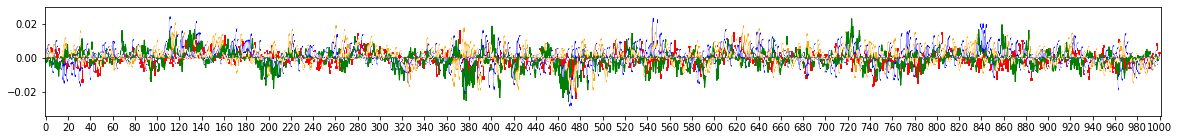

In [11]:
viz_sequence.plot_weights(scores[0], subticks_frequency=20)

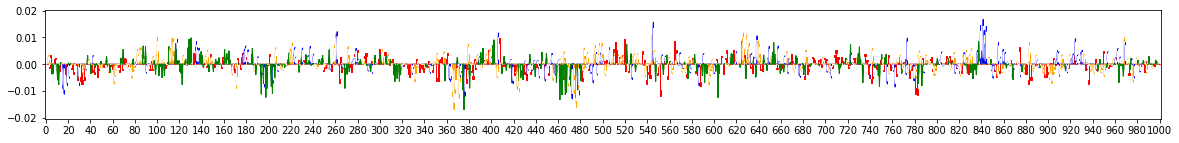

In [12]:
viz_sequence.plot_weights(scores[1][0], subticks_frequency=20)

In [13]:
import shap
from deeplift.visualization import viz_sequence

In [14]:
seqs_to_explain = X

dinuc_shuff_explainer = shap.DeepExplainer(
    #Importance is computed w.r.t. layers[-2] because that corresponds to the logit
    # of the sigmoid; we do this to avoid plateauing of importance scores due to
    # saturation of the sigmoid, as explained in the DeepLIFT paper
    #If you have a regression model, you should likely take layers[-1]
    (keras_model.input, keras_model.layers[-2].output[:,0]), dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

In [15]:
print(seqs_to_explain.shape)
print(shap_explanations.shape)

(100, 1000, 4)
(100, 1000, 4)


In [16]:
def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1):
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

```
for idx,(hypimpscores,orig_seq) in enumerate(zip(shap_explanations,seqs_to_explain)):
    print("Sequence idx",idx)
    print("Actual contributions")
    # (The actual importance scores can be computed using an element-wise product of
    #  the hypothetical importance scores and the actual importance scores)
    viz_sequence.plot_weights(hypimpscores*orig_seq, subticks_frequency=20)
    print("Hypothetical contributions")
    viz_sequence.plot_weights(hypimpscores, subticks_frequency=20)
```

In [10]:
print("\nSaving ...\n")

import h5py
import os
model_ID_out=os.path.basename(model_ID)
model_ID_out


Saving ...



'Model_DeepSTARR'

In [11]:
sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5"

'/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_data/chr17.fa_Model_DeepSTARR_Dex_contribution_scores.h5'

In [12]:
print(fdiry)
os.listdir(fdiry)

/home/mount/work/out/proj_combeffect/peak


['.ipynb_checkpoints',
 'cradle_deepstarr_results',
 'cradle_peak_count',
 'cradle',
 'cradle_deepstarr_data']

In [13]:
fdiry = "/home/mount/work/out/proj_combeffect/peak"
fpath = os.path.join(
    fdiry, 
    "cradle_deepstarr_results", 
    "chr17_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")
fpath

'/home/mount/work/out/proj_combeffect/peak/cradle_deepstarr_results/chr17_Model_DeepSTARR_Dex_contribution_scores.h5'

In [14]:
print("\nSaving ...\n")

import h5py
import os
model_ID_out=os.path.basename(model_ID)

#if (os.path.isfile(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")):
#    os.remove(str(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5"))
#f = h5py.File(sequence_set+"_"+model_ID_out+"_"+class_output+"_contribution_scores.h5")

if (os.path.isfile(fpath)):
    os.remove(str(fpath))
f = h5py.File(fpath)


g = f.create_group("contrib_scores")
# save the actual contribution scores
g.create_dataset(class_output, data=scores[1])
print("Done contr scores for " + class_output)

g = f.create_group("hyp_contrib_scores")
# save the hypothetical contribution scores
g.create_dataset(class_output, data=scores[0])
print("Done hyp scores for " + class_output)

f.close()


Saving ...

Done contr scores for Dex
Done hyp scores for Dex
